
<h1><center>Dimensionality reduction on Manifolds</center></h1>
<h3><center>by Abhijith Atreya</center></h3>
This notebook implements the paper : 

[A. Goh and R. Vidal, "Clustering and dimensionality reduction on Riemannian manifolds," 2008 IEEE Conference on Computer Vision and Pattern Recognition, 2008, pp. 1-7, doi: 10.1109/CVPR.2008.4587422.](https://ieeexplore.ieee.org/document/4587422)



### Introduction

Dimensinality reduction is well understood on euclidian distances when we want to estimate linear components from a higher dimensional space. However, there are several computer vision problems where it is more natural to consider features that
live in a non-Euclidean space like Grassmann manifolds and Lie groups are used for motion segmentation and multibody factorization.

In this notebook we calculate the Local linear embeddding (LLE) on a manifold, which is one of the non linear dimensionality reduction (NLDR) techniques.

We evaluate the LLE for 2 examples of data, one on a hypersphere of 2-dimensions and another on the sklearn's toy dataset

In [1]:
# %%
import os
import sys
import time
import warnings

sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings("ignore")

In [2]:
# All imports
import matplotlib.pyplot as plt
import numpy as np
import geomstats.visualization as visualization
import geomstats.backend as gs
from geomstats.geometry.pullback_metric import PullbackMetric
from geomstats.learning.knn import KNearestNeighborsClassifier
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
from geomstats.learning.preprocessing import ToTangentSpace
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from geomstats.geometry.hypersphere import Hypersphere
import geomstats.visualization as viz
from utils import *

np.random.seed(1)
gs.random.seed(1000)


INFO: Using numpy backend


### Example 1:

Let us generate data on a hypersphere of 2 dimensions. To generate the data, we will take a point on the hypersphere  and project it along a tangent vector. The points along the geodesic, are considered as our input data.

Parameters:
- Manifold : S-curve
- Metric : Hypersphere 
- Samples : 100
- Input dimension : $\textbf{SO}^{3}$
- Output dimension : $\textbf{R}^{m} = \textbf{R}^{2}$
- Number of nearest neighbors : 12

#### Generate data  on the manifold:

In [3]:
# Construct a sequence of points on the hypersphere
sphere = Hypersphere(dim=2)
metric = sphere.metric

point = np.array([-0.65726771, -0.02678122, 0.7531812])

vector = np.array([2, 0, 0.8])

tangent_vector = sphere.to_tangent(vector, base_point=point)

result = sphere.metric.geodesic(initial_tangent_vec=tangent_vector, initial_point=point)
n_samples = 100

points_on_geodesic = result(np.linspace(0.0, 1.0, n_samples))

Let's plot the generated points on the hypershpere

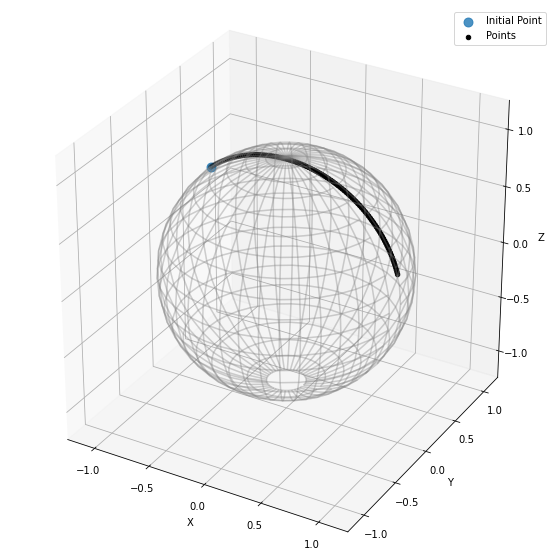

In [4]:
fig = plt.figure(figsize=(10, 10)); ax = fig.add_subplot(111, projection="3d")

ax = viz.plot(point, ax=ax, space="S2", s=80, alpha=0.8, label="Initial Point")
#arrow = viz.Arrow3D(point, vector=tangent_vector); arrow.draw(ax, color="C0", label="Initial Vector")
ax = viz.plot(points_on_geodesic, ax=ax, space="S2", color="black", label="Points")

ax.legend();

Now, we perform LLE on the above generated sythetic data. 

LLE consists of 3 main steps:
1. Find k-nearest neighbors
2. Find the optimal weight matrix
3. Estimate low dimensional vectors

Let's calculate the k-nearest neighbours according to the manifold distance:

In [5]:
# %%
# DIMENSIONALITY REDUCTION
# Local linear embedding
data = points_on_geodesic
n_neighbors = 12  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of coordinates for the manifold

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans( 1)
kmeans.fit(data)
labels = kmeans.predict(data)

k_nearest_vals = Compute_neighbours(data, labels, metric, n_neighbors)

K-nearest values of each point:
[[ 0  1  2  3  4  5  6  7  8  9 10 11]
 [ 1  2  0  3  4  5  6  7  8  9 10 11]
 [ 2  3  1  4  0  5  6  7  8  9 10 11]]


After finding the k-nearest neighbors, we define the data points $x_{i}$ in terms of the local linear relationships within the neighborhood. For each $x_{i}$ in dimension $d$, we reconstruct $x_{i}$  using a linear combination of its k-nearest neighbors, using a weight matrix $ W $

We compute the weights matrix $ W $, which minimizes the Riemannian reconstruction error :
$$
\varepsilon_{\operatorname{Riem}}(W)=\sum_{i=1}^{n}\left\|\sum_{j=1}^{n} W_{i j} \log _{\boldsymbol{x}_{i}}\left(\boldsymbol{x}_{j}\right)\right\|_{\boldsymbol{x}_{i}}^{2}
$$

In [7]:
M, W = Compute_W(data, metric ,k_nearest_vals, n_samples, n_neighbors )

To validate the weights obtained from the above optimization problem, we calculate the linear reconstruction $ \hat{\bar{\text{x}}} = \bar{\text{x}} W$ 

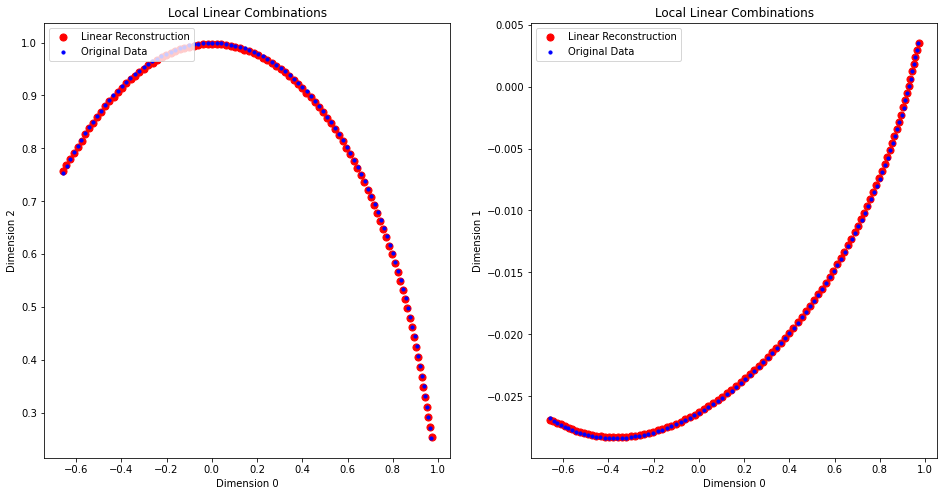

In [8]:
Validate_W(data, W, k_nearest_vals)

From the above figure, we observe that the linearly reconstructed points from the k-nearest weighted neighbours are very close to the original data points $\bar{\text{x}}$.

 Hence using the weight matrix $W$ , we obtain a local linear reconstruction of the original data

Now, we solve for the lower dimensional embedding coordinates $y_{i} \in \textbf{R}^{m} $ that preserve local linear relationships.

 We perform an eigenanalysis of $\widetilde{\textbf{M}}$ and obtain the $(d + 1)$ eigenvectors associated with the smallest $(d + 1) $eigenvalues.
 The $d$ eigenvectors of the matrix $\widetilde{\textbf{M}}$ associated with its second to $(d + 1)$-th smallest eigenvalues correspond to eigenvectors spanning a d-dimensional space which contains the embedding coordinates

In [9]:
embedding, _  = null_space(M,2)
result = embedding

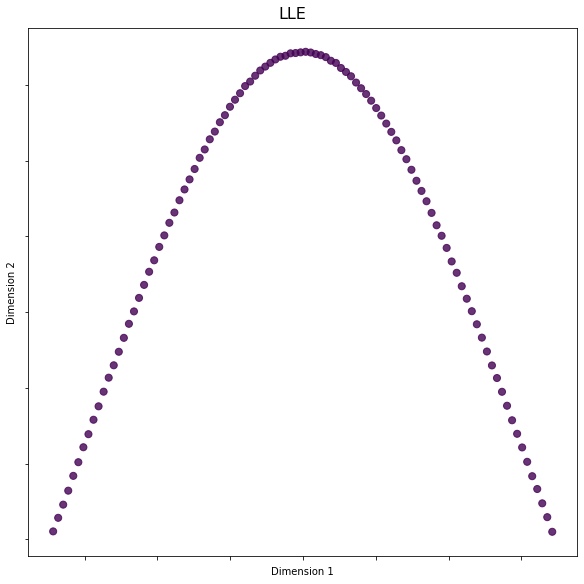

In [10]:
plot_2d(result, labels, 'LLE')

We can see that the shape of the data on the submanifold sort of resembles the data on $\textbf{SO}^{3}$, if we were to slice a plane along the geodesic of the points.

### Example 2:

Now, lets try this technique on a toy dataset from the `sklearn.datasets` package.

We generate 200 points on the `S-curve` manifold in $\textbf{R}^{3}$

Let us apply LLE to this curve to reduce it to $\textbf{R}^{2}$

Parameters:
- Manifold : S-curve
- Metric : Euclidian 
- Samples : 500
- Input dimension : $\textbf{R}^{3}$
- Output dimension : $\textbf{R}^{2}$
- Number of nearest neighbors : 15

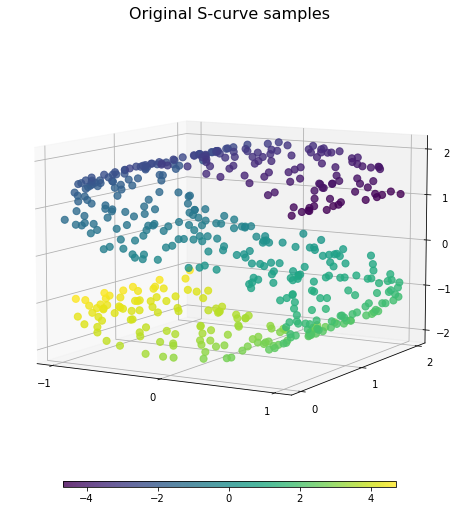

In [11]:
# Test on toy dataset

from sklearn import manifold, datasets

rng = np.random.RandomState(0)

n_samples = 500
S_points, S_color = datasets.make_s_curve(n_samples, random_state=rng)

plot_3d(S_points, S_color, "Original S-curve samples")

The data points on the S-curve manifold, lie as shown above. 

Now we calculate the 12 nearest neighbors of the data points 

In [12]:
n_neighbors = 15  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of coordinates for the manifold

In [13]:
from geomstats.geometry.euclidean import Euclidean

coords = Euclidean(dim=3)
metric = coords.metric

from sklearn.cluster import KMeans

data = S_points
kmeans = KMeans( 1)
kmeans.fit(data)
labels = kmeans.predict(data)

k_nearest_vals = Compute_neighbours(data, labels, metric, n_neighbors)

K-nearest values of each point:
[[  0 436 362 256  33 317  11 107 348 232 170 338  96 267 218]
 [  1 120 438 229 160  93 456 319 369 201 476 463 194 206 253]
 [  2 485  36 185 187 105  73 267 117 424  96  37 218 348 491]]


In [14]:
# Compute W
from utils import *
M, W = Compute_W(data, metric ,k_nearest_vals, n_samples, n_neighbors )

In [15]:
embedding, _  = null_space(M,2)
result = embedding

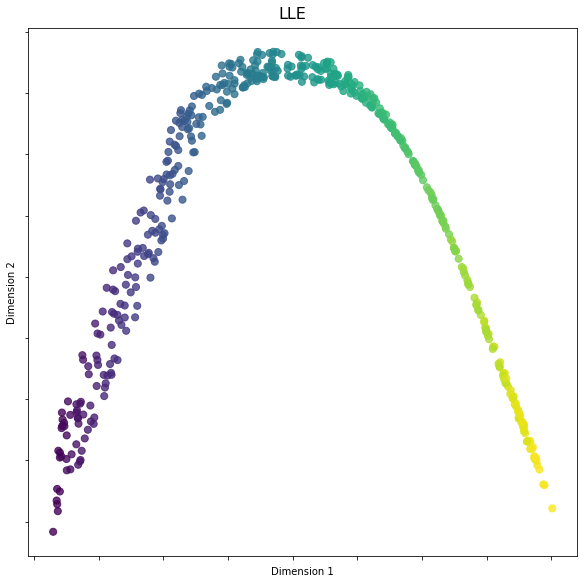

In [16]:
plot_2d(result, S_color, 'LLE')

From the above graph, we see the Local linear embedding of the toy dataset in 2 dimensions.

### Conclusion

We implemented the non-linear dimensionality reduction technique : Local linear embedding which assumes that the local neighborhood of a point on the manifold can be approximated by the affine subspace spanned by the k-nearest neighbors of the point and finds a low-dimensional embedding of the data based on these affine approximations.

This work can also be extended towards other NLDR techniques namely: Laplacian Eigenmaps, Hessian LLE etc..